# Fourier Transformation
## Praktische Anwendung

Dieses Notebook präsentiert eine grundlegende Einführung in die Fourier-Transformation und ihre praktische Anwendung zur Näherung, Analyse und Bearbeitung von periodischen Funktionen.
Die Fourier-Transformation ist ein mächtiges mathematisches Werkzeug, das es ermöglicht, eine Funktion in den Frequenzraum zu übertragen. Dadurch können wir Informationen über die verschiedenen Frequenzkomponenten einer Funktion gewinnen. In diesem Notebook werden wir die Fourier-Transformation anwenden, um verschiedene Funktionen zu fitten, Sonnendaten zu analysieren sowie Musik und Bilder zu bearbeiten.

Die Aufgaben sind in vier Abschnitte unterteilt. 
1. Abschnitt: Wir implementieren die Fourier-Approximation in numpy und passen damit drei verschiedene Funktionen an. Wir vergleichen die Approximationen mit den Originalfunktionen und bestimmen die Anzahl der Fourier-Komponenten, die benötigt werden, um einen bestimmten Fehler zu erreichen.

2. Abschnitt: wir wenden die Fourier-Analyse auf Sonnenfleckendaten an, um die dominante Periodizität der Schwingung und weitere Perioden zu identifizieren. Wir entfernen einige Komponenten im Fourier-Spektrum und führen eine Rücktransformation durch, um die Auswirkungen zu untersuchen.

3. Abschnitt: wir analysieren und bearbeiten ein Musikstück mithilfe der Fourier-Transformation. Wir trennen das Signal in verschiedene Frequenzbereiche und rekonstruieren die gefilterten Signale.

4. Abschnitt: wir analysieren und bearbeiten eine Bilddatei mit Hilfe der Fourier-Transformation. Wir betrachten die Verteilung der Fourier-Komponenten, entfernen Komponenten basierend auf ihrer Amplitude und rekonstruieren das Bild.

## Vorbereitung
Zunächst installieren wir gebrauchte Pakete und laden die Dateien hoch.

In [1]:
from google.colab import files
uploaded = files.upload()
!pip install librosa

Saving img.jpg to img.jpg
Saving music.wav to music.wav
Saving sunspots.txt to sunspots.txt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Dann laden wir die gebrauchten Pakete

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple

## Aufgabe 1: Fourier-Approximation

Zunächst implementieren wir die Fourier-Approximation in numpy.

In [3]:
TWO_PI = 2 * np.pi

def fourier_koeffizient(x: np.array, y: np.array, k: int) -> complex:
    """
    Berechnet den k-ten komplexen Fourier-Koeffizienten (Komponente) für eine Funktion mit Werten y,
    die auf einem Raster von x-Werten im Intervall [-pi, pi] definiert ist. 
    Das Integral wird numerisch mit der Trapezregel (np.trapz) ausgewertet.
    x -- Array von x-Werten
    y -- Array von y-Werten
    k -- Ganzzahl zur Indizierung der Fourier-Komponente
    """
    schrittweite = x[1] - x[0]                 
    integrand = y * (np.cos(x * k) - 1j * np.sin(x * k)) 
    return np.trapz(integrand, dx=schrittweite) / TWO_PI
    

def fourier_approximation(f: Callable[[float], float], a: float, N: int, m: int) -> Tuple[np.array, np.array, np.array, np.array]:
    """
    Berechnet die Fourier-Näherung für eine Funktion f auf einem Intervall [-a, a] (a > 0) mit 2m + 1 Komponenten.
    f -- Funktion zur Näherung
    a -- Skalierung der Funktion definiert auf [-a, a]
    N -- Anzahl der x-Gitterpunkte
    m -- Parameter, der die Anzahl der Fourier-Komponenten 2m + 1 festlegt
    """
    x_werte = np.linspace(-a, a, N)                  
    funktionswerte = f(x_werte)                              
    x_reskaliert = x_werte * np.pi / a
    koeffizienten = np.zeros(2 * m + 1, dtype=complex)
    f0 = fourier_koeffizient(x_reskaliert, funktionswerte, 0)
    koeffizienten[m] = f0
    naeherungswerte = f0 * np.ones(x_werte.shape)
    for k in range(1, m + 1):
        fk = fourier_koeffizient(x_reskaliert, funktionswerte, k)
        fnegk = fourier_koeffizient(x_reskaliert, funktionswerte, -k)
        koeffizienten[m + k] = fk
        koeffizienten[m - k] = fnegk
        naeherungswerte += (fk + fnegk) * np.cos(x_reskaliert * k) + 1j * (fk - fnegk) * np.sin(x_reskaliert * k)
    return x_werte, funktionswerte, naeherungswerte, koeffizienten

Um die Güte einer Approximation zu bestimmen, verwenden wir den relativen Abweichungsfehler:

$$ \text{error} = \frac{1}{N} \sum\limits_{i=0}^{N-1} \left| \frac{y_i - y_{i,\text{approx}}}{y_i} \right|$$

Dieser berechnet den **Mittelwert der prozentuale Abweichung der Approximation $y_{i,\text{approx}}$ vom target $y_i = f(x_i)$ in jedem gesampelten Punkt** der Funktion. 

In [4]:
def error(zielwerte: np.array, approximationswerte: np.array) -> float:
    """
    Berechnet den relativen Fehler der Näherung.
    Der relative Fehler ist der absolute Abstand zwischen Näherung und Ziel im Verhältnis zum Ziel (prozentuale Abweichung).
    Die endgültige Ausgabe ist der Durchschnitt der relativen Fehler für alle abgetasteten Werte.
    zielwerte -- Zielwerte
    approximationswerte -- approximierte Werte
    """
    return np.abs((approximationswerte - zielwerte) / zielwerte).mean()


Nun definieren wir die drei Funktionen, die wir approximieren wollen.

\begin{align*}
f_1(x) &= \frac{1}{{e^{x} + e^{-x}}} \\
f_2(x) &= e^{x} \\
f_3(x) &= e^{|x|}
\end{align*}

In [5]:
def f1(x):
    return 1/(np.exp(x)+np.exp(-x))
label_f1 = r"$f_1(x) = \frac{1}{{e^{x} + e^{-x}}}$"

def f2(x):
    return np.exp(x)
label_f2 = r"$f_2(x) = e^{x}$"

def f3(x):
    return np.exp(np.abs(x))
label_f3 = r"$f_3(x) = e^{|x|}$"


Als erster nähern wir $f_1$ auf dem Interval $[-3,3]$ mit einer Auflösung von $N=600$ Schritten.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


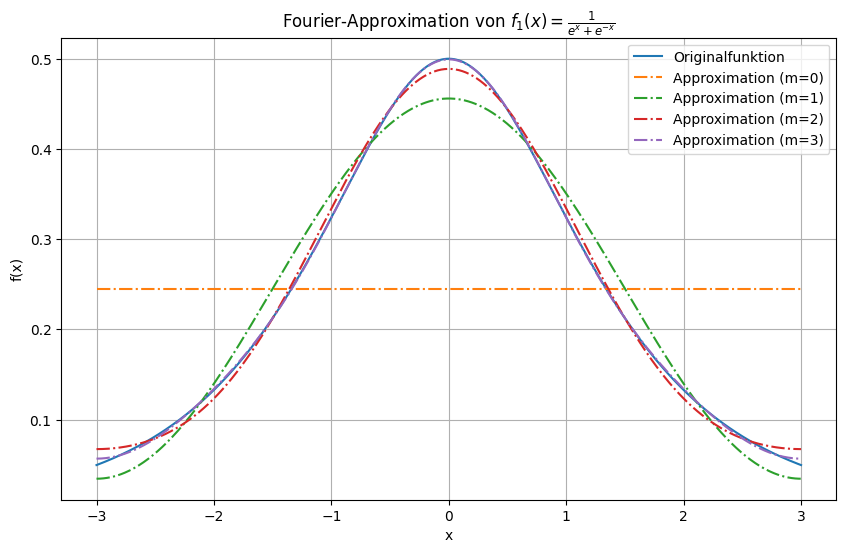

In [6]:
N = 600 ## Die selben Werte werden überall verwendet
a = 3


m_values = [0, 1, 2, 3]  # Verschiedene Anzahlen von Komponenten (2m + 1)

x_original, y_original, _, _ = fourier_approximation(f1, a, N, 0)  # Originalfunktion

plt.figure(figsize=(10, 6))
plt.plot(x_original, y_original, label='Originalfunktion')

for m in m_values:
    x, _, yappr, _ = fourier_approximation(f1, a, N, m)  # Fourier-Approximation
    plt.plot(x, yappr, label=f'Approximation (m={m})', linestyle="-.")

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(r'Fourier-Approximation von $f_1(x) = \frac{1}{{e^{x} + e^{-x}}}$')
plt.legend()
plt.grid(True)
plt.show()




Der Verlauf der Originalfunktion kommt einer Kosinuskurve sehr nahe.

Für $m=0$ erhalten wir nur den nötigen $y$-Achsenabschnitt von $k=0$, damit die Werte positiv bleiben.

Für $m=1$ erhalten wir schon eine prinzipiell recht gute Näherung, die allerdings noch einiger Korrektur bedarf, da die Originalfunktion nicht einer perfekton Kosinuswelle entspricht.

Für $m=3$ erhalten wir bereits eine erstaunlich gute Näherung. Weitere Verbesserungen werden mit dem Auge schwer zu erfassen sein, sondern müssen mit einer geeigneten Metrik, zB dem relativen Fehler, gemessen werden.

Nun bestimmen wir, wieviele Komponenten nötig sind, um die Funktion mit einem Relativen Fehler von weniger als 0.1 % zu erhalten. Dafür verwenden wir wiederholt die folgende Funktion

In [7]:
def obtain_minimal_m(f: Callable[[float], float], desired_error: float = 0.001, m_step: int = 1, label: str = ""):
    """
    Computes the number of components m required to approximate function f with relative error smaller than desired_error.
    f -- function to be approximated
    desired_error -- maximum allowed error. Default: 0.001
    m_step -- stepsize to try different values of m. Default: 1
    """
    ## konstante Funktion als Referenzwert
    m = 0
    x, y, yappr, _ = fourier_approximation(f, a, N, m)
    err = error(y, yappr)
    ms = [m]
    errors = [err]
    err0 = err
    print(f"m={m}:\tFehler = {err:.4f}")
    while  err > desired_error:
        ## Berechnung der Approximation der Funktion sowie des relativen Fehlers 
        ## für steigende Werte von m, bis die gewünschte Genauigkeit erreicht ist.
        m += m_step
        _, _, yappr, _ = fourier_approximation(f, a, N, m)
        err = error(y, yappr)
        ms.append(m)
        errors.append(err)
        print(f"m={m}:\tFehler = {err:.4f}")
        if err0 < err: ## Die Approximation sollte nicht schlechter sein als eine konstante Funktion
            break

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plotte error vs. m
    ax1.plot(ms, errors)
    ax1.set_ylabel('Fehler')
    ax1.set_xlabel('m')
    ax1.set_yscale("log")
    ax1.set_title(f'Fehler der Fourier-Approximation von {label}')
    ax1.grid(True)

    # Plotte die originale Funktion und letzte Approximation
    ax2.plot(x, y, label='Originalfunktion')
    ax2.plot(x, yappr, label=f'Approximation (m={m})', linestyle="-.")
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.set_title(f'Fourier-Approximation von {label}')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout() 
    plt.show()

    print(f'\n\nAnzahl der Fourier-Komponenten für einen maximalen relativen Fehler von 0,1%:\n\nm={m}\n\n')


m=0:	Fehler = 0.9545
m=1:	Fehler = 0.1278
m=2:	Fehler = 0.0483
m=3:	Fehler = 0.0102
m=4:	Fehler = 0.0100
m=5:	Fehler = 0.0067
m=6:	Fehler = 0.0053
m=7:	Fehler = 0.0042
m=8:	Fehler = 0.0035
m=9:	Fehler = 0.0030
m=10:	Fehler = 0.0025
m=11:	Fehler = 0.0022
m=12:	Fehler = 0.0019
m=13:	Fehler = 0.0017
m=14:	Fehler = 0.0015
m=15:	Fehler = 0.0014
m=16:	Fehler = 0.0012
m=17:	Fehler = 0.0011
m=18:	Fehler = 0.0010
m=19:	Fehler = 0.0009


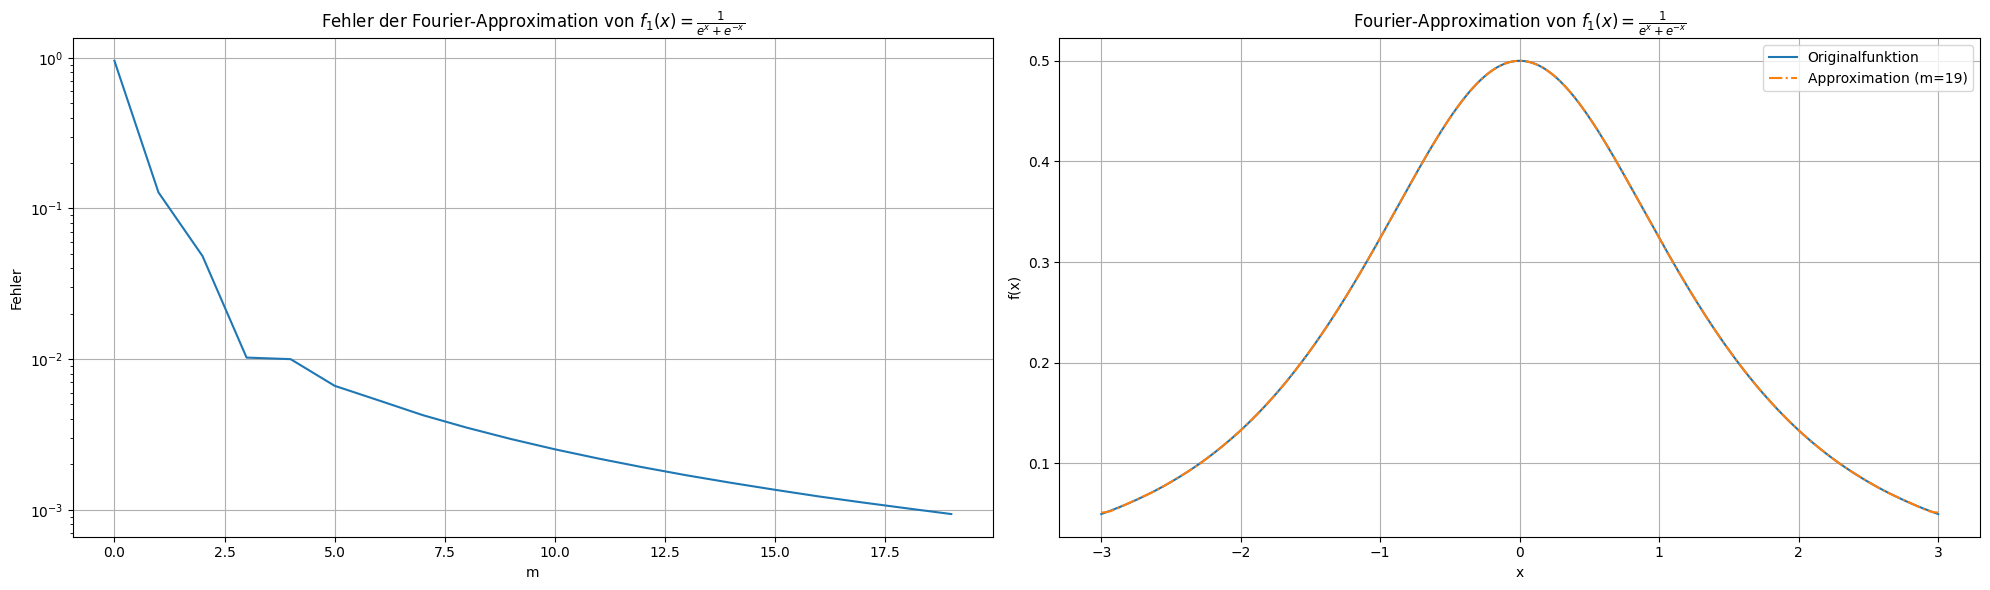



Anzahl der Fourier-Komponenten für einen maximalen relativen Fehler von 0,1%:

m=19




In [8]:
obtain_minimal_m(f1, label=label_f1)

Der numerische Test ergibt, dass **mit $m=19$ Komponenten die gewünschte Genauigkeit** erreicht wird.
Der linke Plot zeigt die Entwicklung des Fehlers mit der Anzahl Komponenten.
Der rechte Plot zeigt die Approximation im Vergleich zur Originalfunktion.
Mit dem Auge ist kein Unterschied erkennbar.

m=0:	Fehler = 10.5095
m=30:	Fehler = 1.9858
m=60:	Fehler = 1.2238
m=90:	Fehler = 0.9177
m=120:	Fehler = 0.7617
m=150:	Fehler = 0.6307
m=180:	Fehler = 0.5593
m=210:	Fehler = 0.4848
m=240:	Fehler = 0.4233
m=270:	Fehler = 0.3714
m=300:	Fehler = 0.3368
m=330:	Fehler = 0.3749
m=360:	Fehler = 0.4268
m=390:	Fehler = 0.4902
m=420:	Fehler = 0.5640
m=450:	Fehler = 0.6567
m=480:	Fehler = 0.7674
m=510:	Fehler = 0.9405
m=540:	Fehler = 1.2561
m=570:	Fehler = 2.1023
m=600:	Fehler = 12.9215


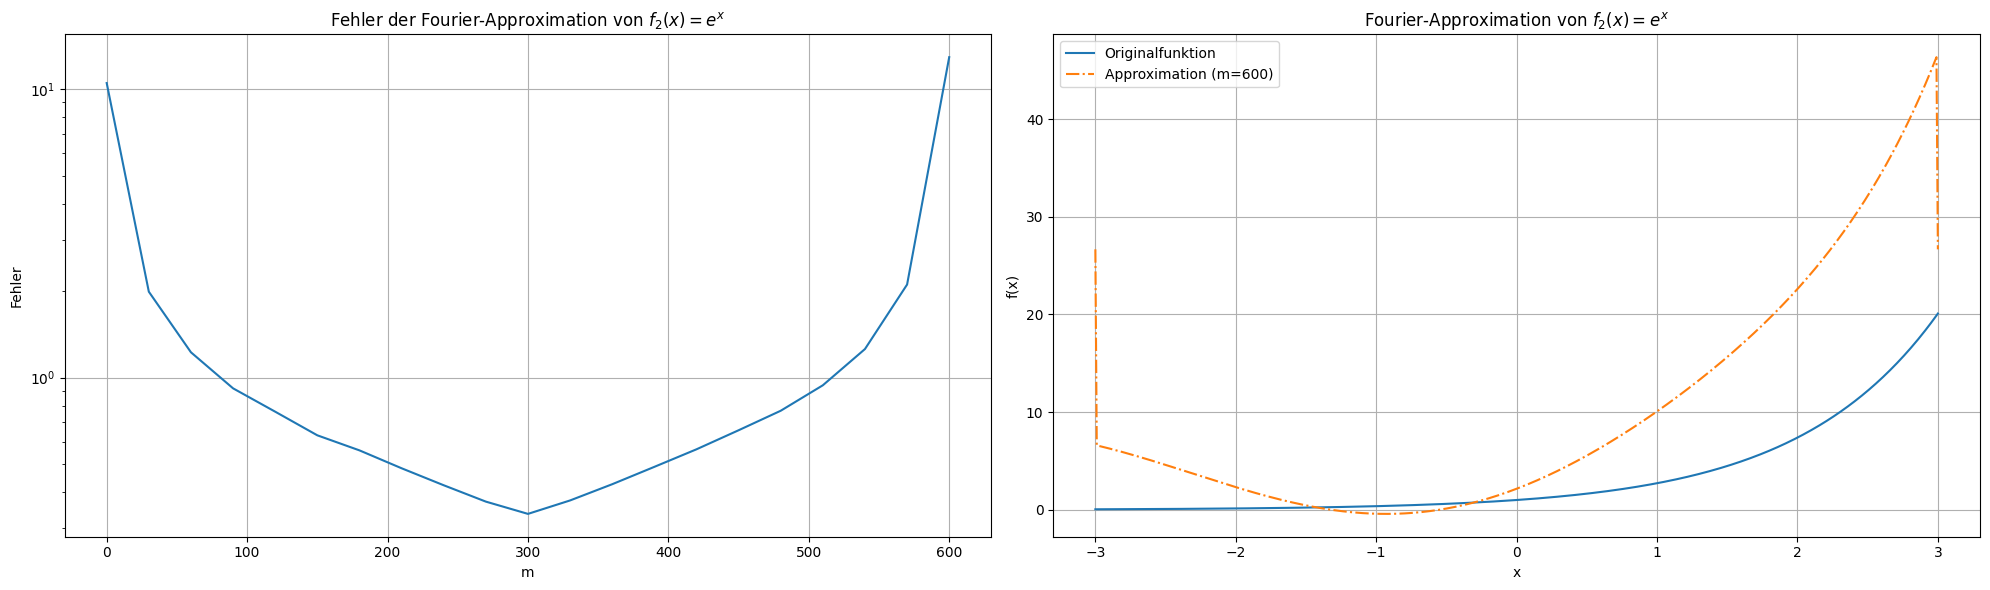



Anzahl der Fourier-Komponenten für einen maximalen relativen Fehler von 0,1%:

m=600




In [9]:
obtain_minimal_m(f2, m_step=30, label=label_f2)

In diesem Fall fällt der relative Fehler nicht monoton mit der Anzahl Komponenten $m$. Die finale Approximation mit $m=600$ liefert einen schlechteren Fehler als die Originalfunktion. Im rechten Plot können wir erkennen, dass der Mittelwert der Schwingung der Fourierapproximation (Werte bei -3 und +3) bei ca. 25, oberhalb des höchsten Funktionswerts liegt. Der Grund dafür ist das Aliasing: Die Frequenz $k=600$ ist genausohoch wie die Sampling Frequenz für $N=600$ Schritte. Deswegen wird diese Schwingung immer mit dem selben Wert gemessen und gibt einen $y$-Achsenabschnitt zusätzlich zu $k=0$. Da $k=0$ aber bereits den gebrauchten Wert liefert, sollte unsere Approximation mit $m < 600$ stattfinden.

Im linken Plot sehen wir, dass die **beste Approximation mit $m=300$ gegeben** ist.
Eine bessere Approximation ist (auch mit $m>600$) nicht möglich, da es sich **bei $f_2(x) = e^x$ nicht um eine periodische Funktion handelt und die Fourierapproximation somit am Rande Periode einen Sprung machen muss**.

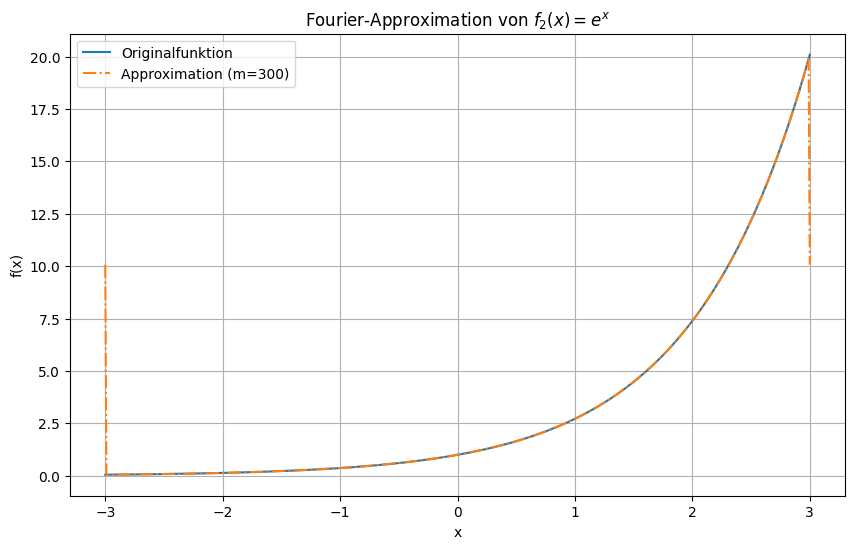

Relativer Fehler: 0.33676014598179305
Relativer Fehler (ohne Ränder): 0.0005678491377557659


In [10]:
m = 300
x, y, yappr, _ = fourier_approximation(f2, a, N, m)

plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Originalfunktion')
plt.plot(x, yappr, label=f'Approximation (m={m})', linestyle="-.")
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title(f'Fourier-Approximation von {label_f2}')
plt.legend()
plt.grid(True)
plt.show()

print(f"Relativer Fehler: {error(y, yappr)}")

print(f"Relativer Fehler (ohne Ränder): {error(y[1:-1], yappr[1:-1])}")



Die Approximation mit $m=300$ liefert, bis auf die Ränder, eine brauchbare Näherung, die unserem Kriterium entspricht.
Der relative Fehler mit Rändern ist hingegen recht hoch. Dies liegt insbesondere am Wert bei $x=-3$: 

$$y < 0.1, \qquad y_{\text{approx}} = 10 \qquad \implies \qquad \left| \frac{y - y_{\text{approx}}}{y} \right| > 100$$

Für Fourier Approximationen von nicht-periodischen oder nicht-stetigen Funktionen sind die Näherungen an den Unstetigkeitsstellen nicht gut durch den relativen Fehler representiert und mit Vorsicht zu verwenden.

m=0:	Fehler = 1.3249
m=2:	Fehler = 0.2148
m=4:	Fehler = 0.0799
m=6:	Fehler = 0.0413
m=8:	Fehler = 0.0252
m=10:	Fehler = 0.0170
m=12:	Fehler = 0.0123
m=14:	Fehler = 0.0093
m=16:	Fehler = 0.0073
m=18:	Fehler = 0.0059
m=20:	Fehler = 0.0048
m=22:	Fehler = 0.0041
m=24:	Fehler = 0.0035
m=26:	Fehler = 0.0030
m=28:	Fehler = 0.0026
m=30:	Fehler = 0.0023
m=32:	Fehler = 0.0020
m=34:	Fehler = 0.0018
m=36:	Fehler = 0.0016
m=38:	Fehler = 0.0015
m=40:	Fehler = 0.0013
m=42:	Fehler = 0.0012
m=44:	Fehler = 0.0011
m=46:	Fehler = 0.0010
m=48:	Fehler = 0.0010


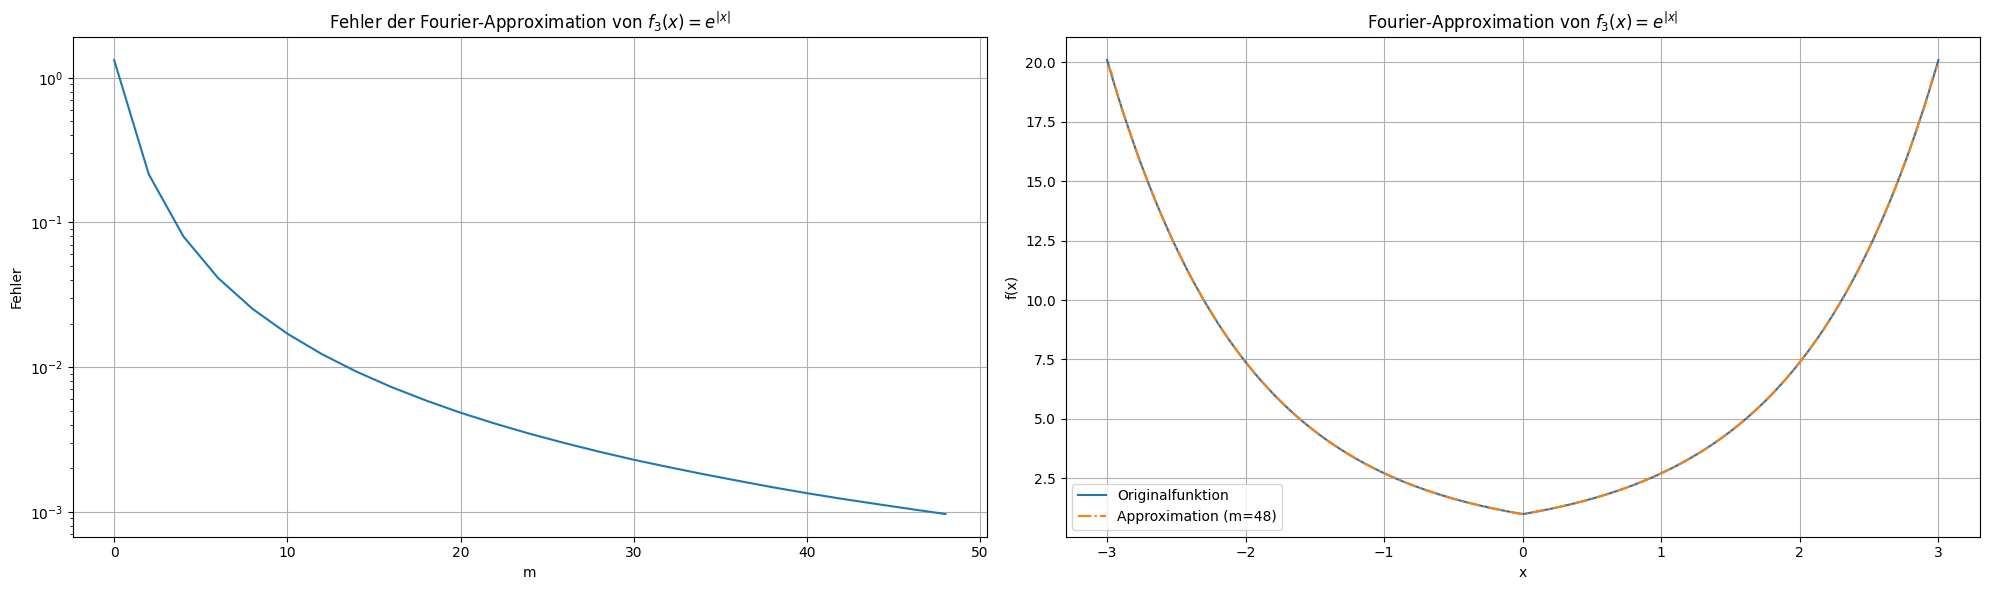



Anzahl der Fourier-Komponenten für einen maximalen relativen Fehler von 0,1%:

m=48




In [11]:
obtain_minimal_m(f3, m_step=2, label=label_f3)

Die Funktion $f_3$ hat wiederum Ähnlichkeit mit einer Kosinus Schwingung. Auch wenn $f_3$ an den Stellen $x= -3, 0, 3$ nicht stetig differenzierbar ist, sind die Näherungswerte sehr gut zu gebrauchen und **$m=48$ Komponenten reichen für einen Fehler $< 0.1 \%$**.

Wir haben festgestellt, dass Signale mit einer **sinusartigen Schwingung, wenn sie nur über einen Zeitraum von einer Periode betrachtet werden, hauptsächlich durch die Grundfrequenz (k=1) bestimmt** werden. **Um die Schwingung an die ursprünglichen Daten anzupassen, werden höhere Frequenzen verwendet**. Dabei werden nur relativ wenige Frequenzen benötigt, um eine gute Annäherung zu erzielen.

Jedoch ist es nahezu **unmöglich, eine gute Approximation an unstetigen Stellen** zu erhalten. Es wird empfohlen, diese Randbereiche zu vermeiden.

Darüber hinaus haben wir festgestellt, dass bei einer **Reihe von N Datenpunkten Frequenzen höher als k=N-1 in der Fourier-Approximation vermieden werden sollten**, da dies zu erheblich schlechteren Ergebnissen aufgrund des Aliasing-Effekts führt.

## Aufgabe 2: Sonnenflecken

In diesem Teil analysieren wir historische Daten zur Zählung von Sonnenflecken.
Wir beginnen damit, die benötigten Pakete sowie die Daten zu laden.

In [12]:
import scipy
from scipy.fft import fft, ifft, fftfreq, fft2,ifft2

(315,) (315,)


Text(0.5, 1.0, 'Wellenform')

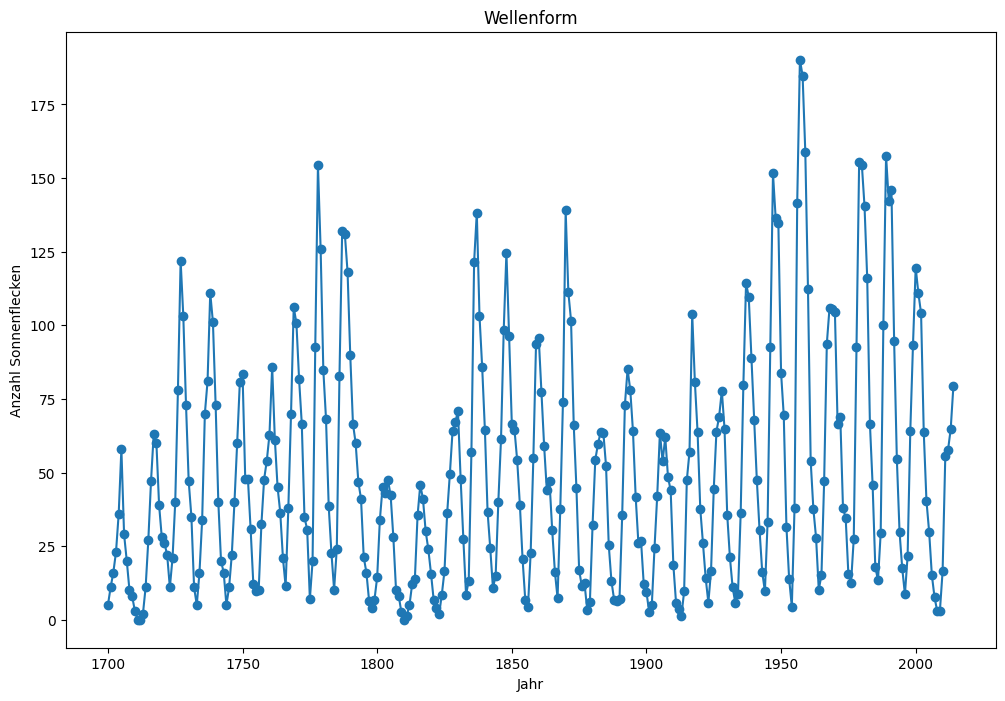

In [13]:
def load_data(path='./sunspots.txt'):
    ss_ = np.loadtxt(path)
    ss_ = ss_.reshape(63*5,2);
    year = ss_[:,0];
    N_spots = ss_[:,1]
    print(year.shape, N_spots.shape)
    return year, N_spots

year, N_spots = load_data()
plt.figure(1, figsize=(12,8))
plt.plot(year, N_spots,'o-')
plt.xlabel("Jahr")
plt.ylabel("Anzahl Sonnenflecken")
plt.title("Wellenform")


In der Anzahl der Sonnenflecken lässt sich über die Jahre unschwer ein Trend erkennen: Im Zyklus von etwa 10 Jahren wechselt die Sonne zwischen vielen (>50) und fast keinen Sonnenflecken pro Jahr. Im folgenden werden wir diesen Zyklus mithilfe des Fourierspektrums genauer analysieren.

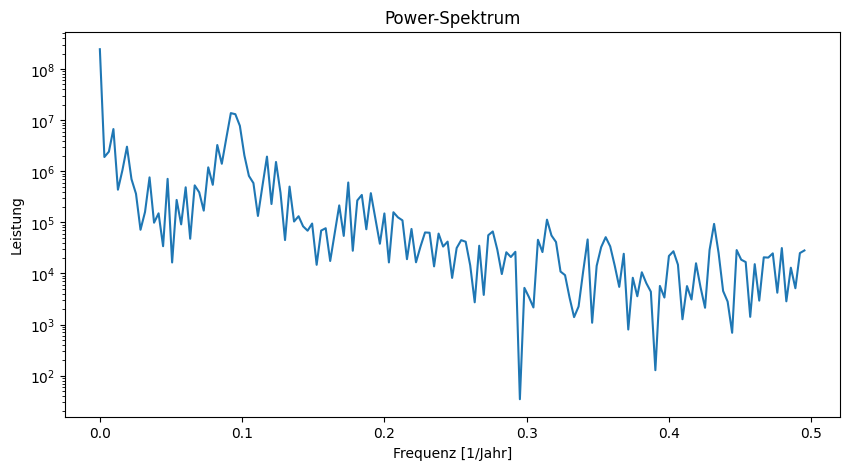

Dominante Periodizität bei k = 0.09/Jahr: 11.25 Jahre


In [14]:
# Fourier-Transformation
N = len(year)
T = year[1] - year[0]  # Abtastintervall

f = fft(N_spots)  # Fourier-Transformation
f_abs = np.abs(f)  # Betrag des Fourier-Transformierten
f_abs = f_abs[:N//2]  # Nur die erste Hälfte (positive Frequenzen) betrachten
spectrum = f_abs**2


# Frequenzen
freqs = fftfreq(N, T)[:N//2] # zur besseren Lesbarkeit verwenden wir Frequenzen, die auf das Abtastintervall abgestimmt sind


# Power-Spektrum plotten
plt.figure(figsize=(10, 5))
plt.plot(freqs, spectrum)  # Quadrat des Betrags = Leistung
plt.xlabel('Frequenz [1/Jahr]')
plt.ylabel('Leistung')
plt.yscale("log")
plt.title('Power-Spektrum')
plt.show()

# Dominante Periodizität
dominant_freq = freqs[np.argmax(spectrum[1:])]  ## betrachte nur k>0
dominant_period = 1 / dominant_freq
print(f'Dominante Periodizität bei k = {dominant_freq:.2f}/Jahr: {dominant_period} Jahre')

Die Analyse des Spektrums zeigt ein eindeutiges Peak bei $k\approx 0.09/\text{Jahr}$ was dem **11.25 jährigen Zyklus der Sonnenaktivität** entspricht.  (mit 314 Jahren Gesamtdauer des Signals entspricht das $k= 28 \approx 314/11.25$, also der Anzahl Berge im Wellenplot. Mit dieser Frequenz dreht sich das Magnetfeld der Sonne um, was bisher noch nicht vollständig ergründete Auswirkungen auf die Zahl der Sonnenflecken hat.)


Eine **weiteres Peak finden wir (nicht mit argmax) bei $k \approx 0.18/\text{Jahr}$, der doppelten Frequenz, was etwa 5.5 Jahren entspricht**. Hierbei handelt es sich um die erste Oberschwingung (auch "harmonische" genannt) des Sonnenzyklus.

[Bemerkung zur Korrektur: wenn andere weitere Peaks erkannt und beschrieben wurden, ist das auch in Ordnung]

Als nächstes Bearbeiten wir das Spektrum mit einem High-Pass sowie einem Low-Pass Filter, in dem die Amplitude von niedrigen bzw hohen Frequenzen auf 0 gesetzt wird.

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


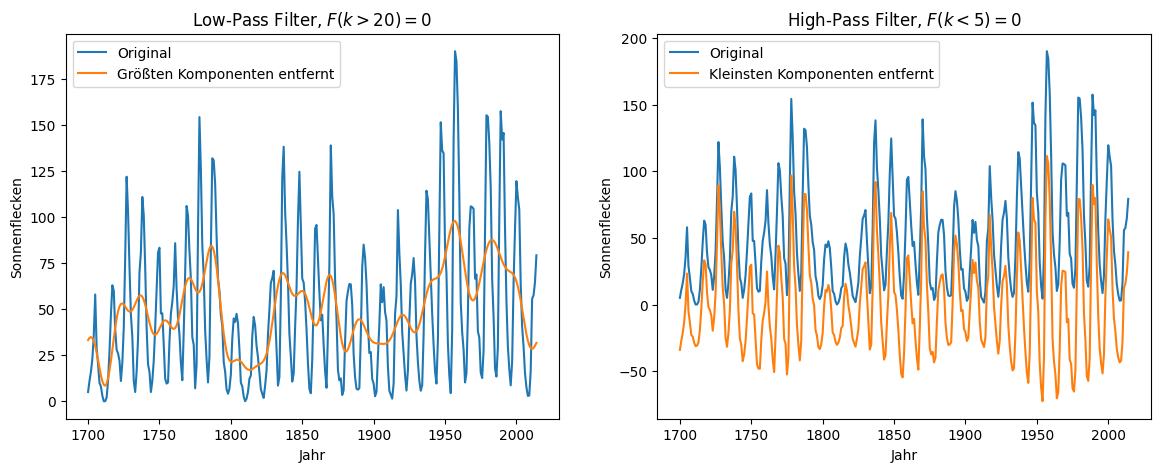

In [15]:
f = fft(N_spots)  # komplexe Koeffizienten der Fourier-Transformation
f_abs = np.abs(f)  # reeller Betrag des Fourier-Transformierten


# Frequenzen
freqs = fftfreq(N, 1./N)  # in diesem Fall betrachten wir die ganzzahligen Frequenzen k=1,2,3,... 

f_low_pass = f.copy()
f_low_pass[np.abs(freqs) > 20] = 0  # wir müssen sowohl positive als auch negative k Filtern.
x_low_pass = ifft(f_low_pass)

f_high_pass = f.copy()
f_high_pass[np.abs(freqs) < 5] = 0
x_high_pass = ifft(f_high_pass)

# Plotten der rücktransformierten Daten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(year, N_spots, label='Original')
ax1.plot(year, x_low_pass, label='Größten Komponenten entfernt')
ax1.set_xlabel('Jahr')
ax1.set_ylabel('Sonnenflecken')
ax1.set_title(f"Low-Pass Filter, $F(k>20)=0$")
ax1.legend()

ax2.plot(year, N_spots, label='Original')
ax2.plot(year, x_high_pass, label='Kleinsten Komponenten entfernt')
ax2.set_xlabel('Jahr')
ax2.set_ylabel('Sonnenflecken')
ax2.set_title(f"High-Pass Filter, $F(k<5)=0$")
ax2.legend()

plt.show()

Der linke Plot zeigt das Ergebnis des low-pass Filters, der nur niedrige Frequenzen, dh langwellige Schwingungen zeigt. Insbesondere ist die Frequenz des Sonnenzyklus $k=28$ nicht enthalten. **Daher reproduziert die Rekonstruktion nicht die Schwankungen des Sonnenzyklus, sondern wie sich die Anzahl der Sonnenflecken im Maximum des Zyklus entwickeln**. (Da das Minimum immer etwa bei 0 bleibt, hat es wenig Einfluss auf den Verlauf.)

Der rechte Plot zeigt das Ergebnis des high-pass Filters, der nur hohe Frequenzen, dh kurzwellige Schwingungen zeigt. **Insbesondere wird der konstante Beitrag von $k=0$ gefiltert, weshalb negative Werte für die Zahl der Sonnenflecken angezeigt werden**, obwohl diese physikalisch keinen Sinn ergeben.
**Diese Rekonstruktion zeigt ungefähr, wie sich die Zahl der Sonnenflecken von Jahr zu Jahr ändern.** Dabei fehlt jedoch zB die Information, dass von 1950 - 2000 ungewöhnlich viele Sonnenflecken beobachtet wurden.

Hier haben wir ein sich im Grunde **wiederholendes, dabei aber staendig veraenderndes Signal** betrachtet. Wir konnten zeigen, dass die **hohen Frequenzen massgeblich das sich wiederholende Signal bestimmen, die niedrigen Frequenzen die Veränderung dieses Signals mit der Zeit**.

Im Gegensatz dazu haben wir in Aufgabe 1, insbesondere bei $f_1$ und $f_3$, **nur eine Periode des Signals gefittet** und eine perfekte Wiederholung angenommen. Dabei zeigte sich, dass **vornehmlich die niedrigste Frequenz $k=1$ die Form des Resultats angibt** und die **höheren Frequenzen zur Angleichung** an die Originalfunktion dienen.

Die Schlussfolgerung daraus ist, dass die **Anzahl der Durchläufe der grössten Schwingung die dominante Frequenz bestimmt**. **Niedrigere Frequenzen bestimmen die Veränderung über die Schwingungen hinweg**, während **höhere Frequenzen vornehmlich zur Feinanpassung** der Approximation an das Original dienen.

## Aufgabe 3
In diesem Teil analysieren und Bearbeiten wir ein Musikstück mithilfe der Fouriertransformation.

Als erstes Laden wir die Audiodatei und hören sie uns an.


In [16]:
import numpy as np
import scipy.fft
import soundfile as sf
import librosa
import matplotlib.pyplot as plt

In [17]:
from IPython.display import Audio

music_file = 'music.wav'
Audio(music_file)


Nun erstellen wir einen Wellenplot, der die Schwingung der Audiodatei darstellt.

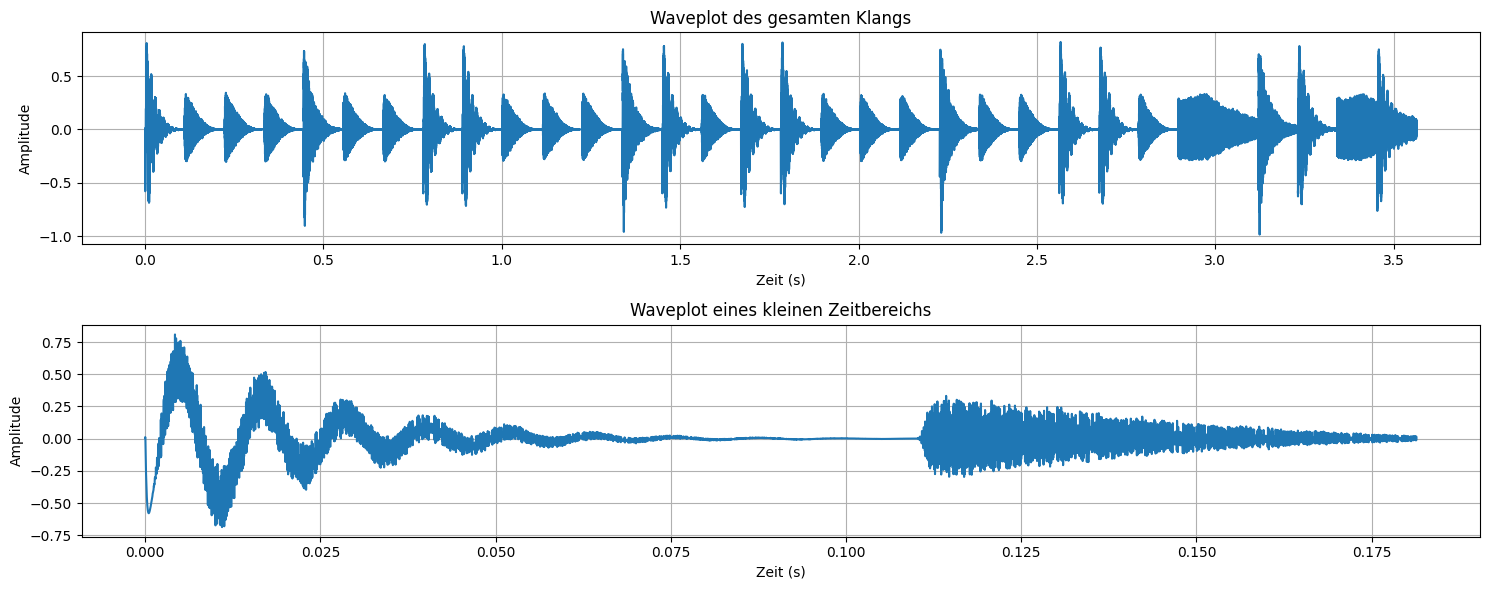

In [18]:
#data, samplerate = sf.read(music_file)
data, samplerate = librosa.load(music_file, sr=None, mono=True, offset=0.0, duration=None)
time = np.arange(0, len(data)) / samplerate
N = len(data)

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.title('Waveplot des gesamten Klangs')
plt.xlabel('Zeit (s)')
plt.ylabel('Amplitude')
plt.grid()

# Plotten Sie einen kleinen Zeitbereich
plt.subplot(2, 1, 2)
plt.plot(time[:8000], data[:8000])
plt.title('Waveplot eines kleinen Zeitbereichs')
plt.xlabel('Zeit (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.tight_layout()
plt.show()



Im oberen Wellenplot sieht man die einzelnen Geräusche der Instrumente. Der Ausschlag der Welle zeigt die Lautstärke an. Das verschwinden der Welle zeigt den Nachhall.

Im unteren Wellenplot sehen wir die ersten beiden Geräusche genauer. Das erste Geräusch ist massgeblich von einer niedrigfrequenten Welle (Bassdrum) bestimmt, die mit einer sehr hochfrequenten Welle (HiHat) überglagert ist. Das zweiten Geräusch besteht nur aus der hochfrequenten Welle (HiHat).

Als nächstes betrachten wir das Fourierspektrum der Audiodatei.

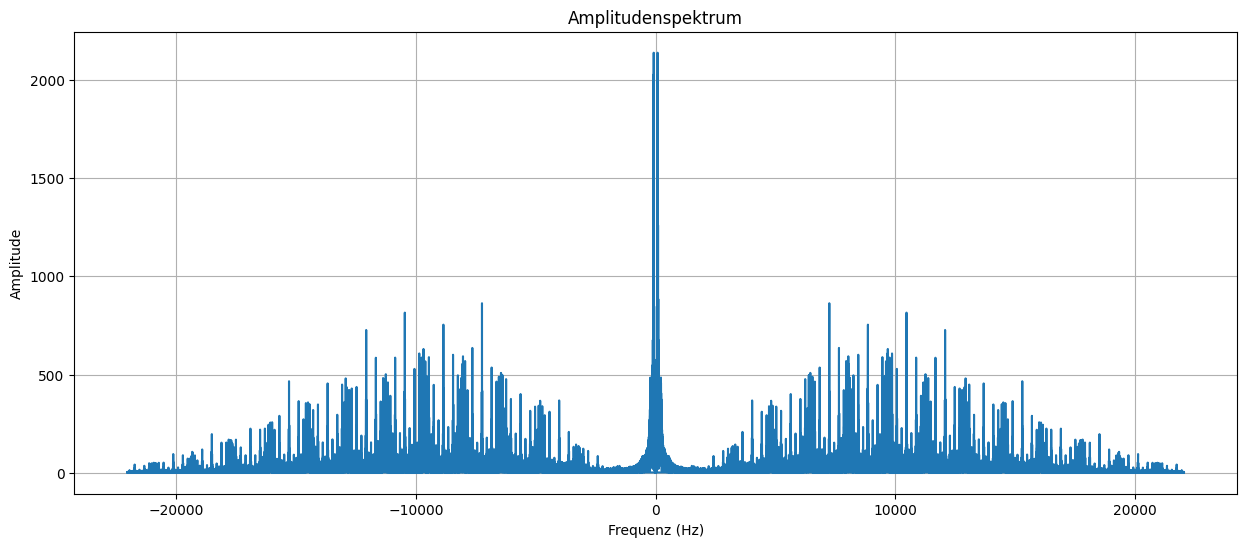

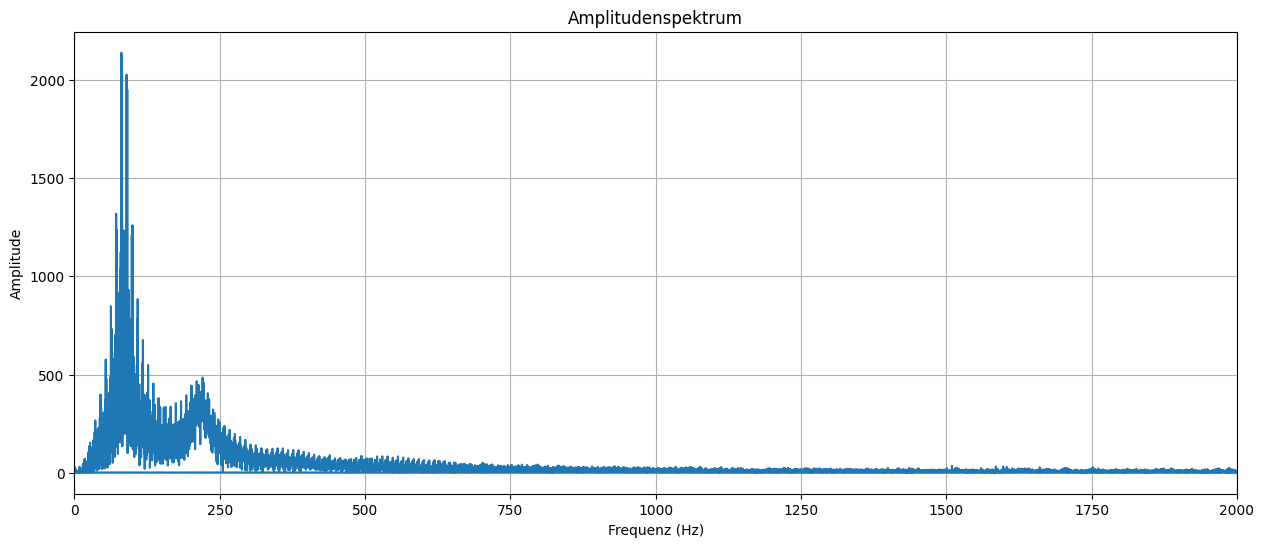

In [19]:
# Plotten Sie das Amplitudenspektrum
fft_result = scipy.fft.fft(data)
frequencies = scipy.fft.fftfreq(N, 1 / samplerate)
fft_result_shifted = scipy.fft.fftshift(fft_result)

plt.figure(figsize=(15, 6))
plt.plot(frequencies, np.abs(fft_result))
plt.title('Amplitudenspektrum')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(frequencies, np.abs(fft_result))
plt.title('Amplitudenspektrum')
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.xlim(0,2000)
plt.show()

Im oberen Plot sehen wir das gesamte Spektrum für positive und negative Frequenzen. Dieses **erscheint perfekt symmetrisch zu sein, weil nur der reele Betrag der komplexen Koeffizienten gezeigt wird**.
Das analysierte **Audiosignal ist strikt reel**, nicht komplex. **Demnach muss auch die Summe der Komponenten, die aus der Diskreten Fourier Transformation (DFT) bzw Fast Fourier Transform (FFT) hervorgehen, strikt reell sein**. Wenn der Fourier Koeffizient der Frequenz $k$ einen imaginären Anteil hat, ist die einzige Möglichkeit diesen auszugleichen eine exakt entsprechende, negierte bzw entgegengesetzte imaginäre Komponente bei der Frequenz $-k$. Aus diesem Grund folgt aus der Definition der DFT: dass **für ein strikt reelles Signal die Fourier Koeffizienten der Frequenzen $k$ und $-k$ konjugiert symmetrisch sind und damit den selben Betrag haben**: 
$$c_k = \overline{c_{-k}}$$

Im unteren Plot sehen wir das positive Spektrum bis 2 kHz.
Dieses zeigt, dass ein deutlicher Abstand zwischen den Tönen niedriger Frequenz (Bassdrum und Snare) und jenen höherer Frequenz liegt (Hihat).

Im Weiteren filtern wir das Spektrum oberhalb und unterhalb von 2 kHz und rekonstruieren die Audiodatei aus den gefilterten Spektren.
Dann berechnen wir die Abweichung dieser Rekonstruktionen vom Original.
Da die Audiodatei an manchen Stellen den Wert 0 annimmt, müssen wir die Berechnung des relativen Fehlers anpassen, um nicht durch 0 zu teilen.

In [20]:
def error(zielwerte: np.array, approximationswerte: np.array) -> float:
    """
    Berechnet den relativen Fehler der Näherung.
    Um eine Division durch 0 zu vermeiden, wird der relative Fehler nur für y != 0 berechnet.
    Der relative Fehler ist der absolute Abstand zwischen Näherung und Ziel im Verhältnis zum Ziel (prozentuale Abweichung).
    Die endgültige Ausgabe ist der Durchschnitt der relativen Fehler für alle abgetasteten Werte.
    zielwerte -- Zielwerte
    approximationswerte -- approximierte Werte
    """
    relative_fehler = np.zeros_like(zielwerte)
    
    # Berechne relative Fehler für nicht-null Zielwerte, andere bleiben bei 0
    benutze = zielwerte != 0
    relative_fehler[benutze] = np.abs((approximationswerte[benutze] - zielwerte[benutze]) / zielwerte[benutze])
    
    return relative_fehler.mean()


In [21]:
# Trennen des Sound-Signals in einen Teil oberhalb und unterhalb von 2 kHz in Frequenzen
mask_below_2k = np.abs(frequencies) < 2000
mask_above_2k = np.abs(frequencies) >= 2000

fft_below_2k = fft_result * mask_below_2k
fft_above_2k = fft_result * mask_above_2k

# Identifizieren der Top 5 Frequenzen in diesen Frequenzbereichen
top_5_below_2k = np.argsort(np.abs(fft_below_2k[frequencies>0]))[-5:]
top_5_above_2k = np.argsort(np.abs(fft_above_2k[frequencies>0]))[-5:]

print('Top 5 Frequenzen unterhalb von 2 kHz (Hz):', np.round(frequencies[top_5_below_2k],0))
print('Top 5 Frequenzen oberhalb von 2 kHz (Hz):', np.round(frequencies[top_5_above_2k],0))

# Berechnen der Rekonstruktionen
reconstructed_below_2k = scipy.fft.ifft(fft_below_2k).real
reconstructed_above_2k = scipy.fft.ifft(fft_above_2k).real

# Berechnen des Fehlers
error_below_2k = error(data, reconstructed_below_2k)
error_above_2k = error(data, reconstructed_above_2k)

print('\nRelativer Fehler der Rekonstruktion unterhalb von 2 kHz:', error_below_2k)
print('Relativer Fehler der Rekonstruktion oberhalb von 2 kHz:', error_above_2k)

# Schreiben der gefilterten rekonstruierten Daten in eine wav-Datei
sf.write('reconstructed_below_2k.wav', reconstructed_below_2k, samplerate)
sf.write('reconstructed_above_2k.wav', reconstructed_above_2k, samplerate)

Top 5 Frequenzen unterhalb von 2 kHz (Hz): [72. 91. 90. 82. 81.]
Top 5 Frequenzen oberhalb von 2 kHz (Hz): [ 7649. 12078.  8857. 10467.  7247.]

Relativer Fehler der Rekonstruktion unterhalb von 2 kHz: 1.9279824
Relativer Fehler der Rekonstruktion oberhalb von 2 kHz: 1.5631989


Nun hören wir uns das Ergebnis im Vergleich zum Original an.

In [22]:
Audio(music_file)

In [23]:
Audio('reconstructed_below_2k.wav')

In [24]:
Audio('reconstructed_above_2k.wav')

Die erste Rekonstruktion aus den **niedrigen Frequenzen enthält ein dumpfes Gespann von Bassdrum und Snare** sowie die niedrigfrequenten Schlaggeräusche der Hihat. 

Die zweite Rekonstruktion aus den **hohen Frequenzen enhält den Klang der HiHat**.

**In beiden Rekonstruktionen fehlt jeweils der Anteil aus der anderen Rekonstruktion**. Allerdings klingen die hohen Frequenzen der HiHat ohne die niedrigen voller und besser als die tiefen Frequenzen von Bass und Snare. Der volle Klang dieser Instrumente besteht aus vielen Obertönen, die im Spektrum zwar nicht weiter auffallen, aber für das menschliche Gehör gut wahrnehmbar sind.

Bonus: plot der Rekonstruierten Wellen

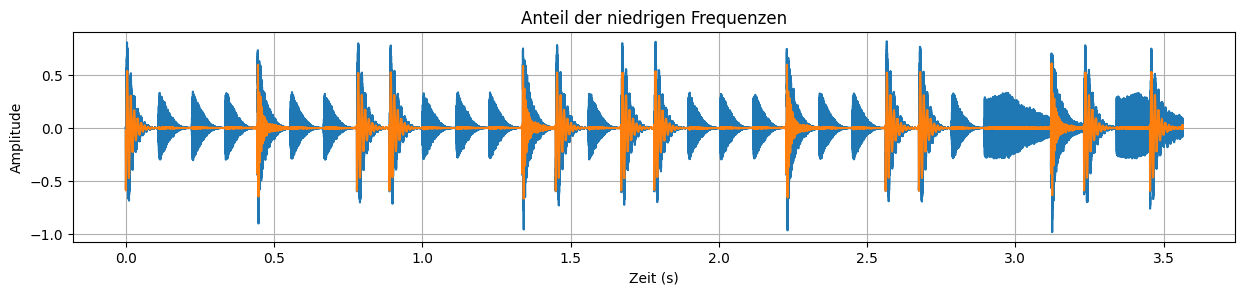

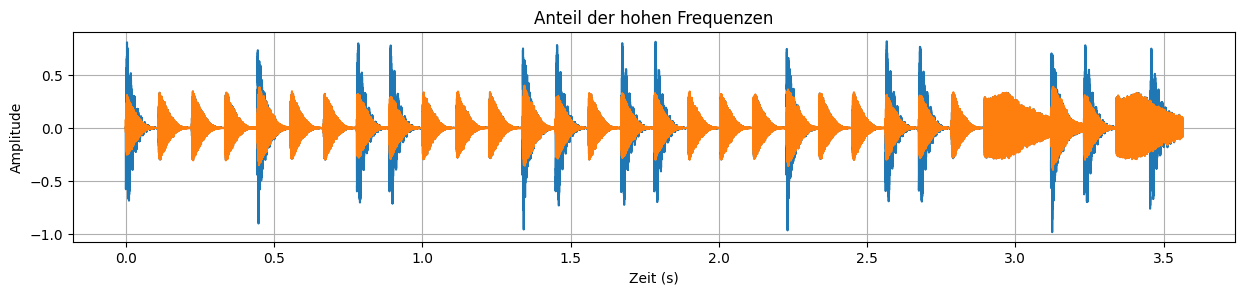

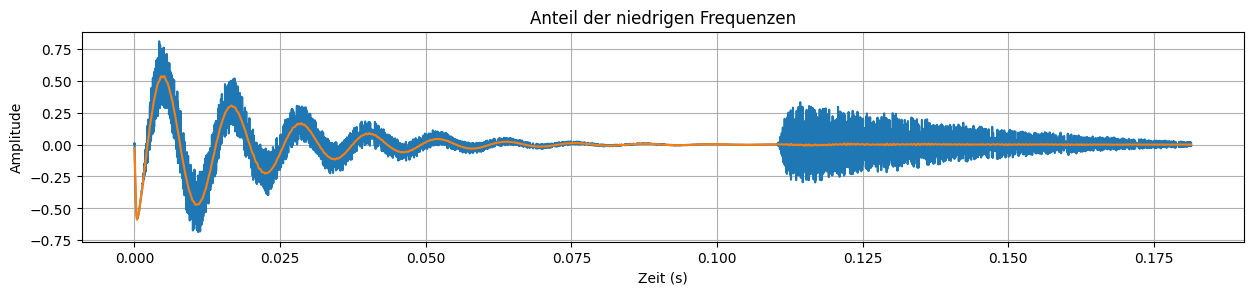

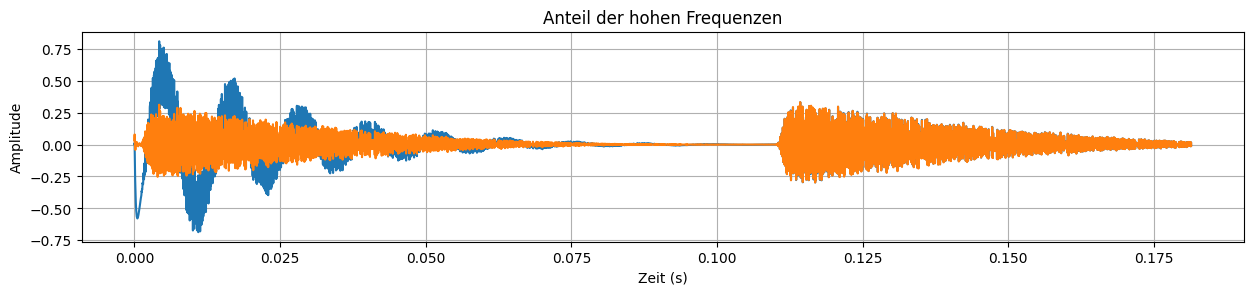

In [25]:
plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.plot(time, reconstructed_below_2k)
plt.title('Anteil der niedrigen Frequenzen')
plt.xlabel('Zeit (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(time, data)
plt.plot(time, reconstructed_above_2k)
plt.title('Anteil der hohen Frequenzen')
plt.xlabel('Zeit (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()



plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(time[:8000], data[:8000])
plt.plot(time[:8000], reconstructed_below_2k[:8000])
plt.title('Anteil der niedrigen Frequenzen')
plt.xlabel('Zeit (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.plot(time[:8000], data[:8000])
plt.plot(time[:8000], reconstructed_above_2k[:8000])
plt.title('Anteil der hohen Frequenzen')
plt.xlabel('Zeit (s)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


Mit den rekonstruierten Wellen können wir gut nachvollziehen, welches Geräusch von welchem Instrument kommt. Im gut aufgelösten ersten Geräusch wird nun sehr deutlich, welcher Klanganteil von welchen Instrument kommt.

## Aufgabe 4

Im letzten Teil dieses Notebooks Transformieren wir eine Bilddatei mit dem Ziel, eine möglichst platzsparende Methode zum Abspeichern zu finden, die das Originalbild erhält.

Zunächst laden wir das Bild und zeigen es zusammen mit der Fourier Transformierten.

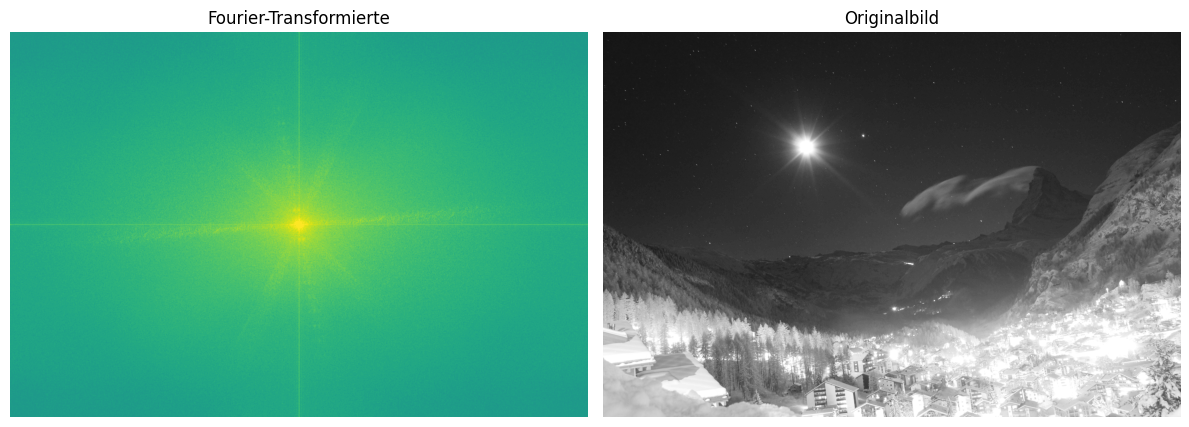

In [26]:
import numpy as np
from scipy.fftpack import fft2, ifft2, fftshift
import matplotlib.pyplot as plt
from PIL import Image

# Lade das Bild und konvertiere es in Graustufen
img = Image.open('img.jpg').convert('L')


# Berechne die 2D Fourier-Transformation
fft_img = fft2(img)

# Verschiebe die Fourier-Transformierte, sodass die niedrigsten Frequenzen in der Mitte liegen
fft_shift = fftshift(fft_img)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plotte das Originalbild
axs[1].imshow(img, cmap='gray')
axs[1].set_title('Originalbild')
axs[1].axis('off')

# Plotte die 2D-Verteilung der absoluten Werte der Fourier-Komponenten
axs[0].imshow(np.log10(np.abs(fft_shift)), vmin=0, vmax=6)
axs[0].set_title('Fourier-Transformierte')
axs[0].axis('off')

# Zeige die Figur an
plt.tight_layout()
plt.show()




Das linke Bild zeigt das Fourierspektrum. $k_x$ sind entlang der $x$-Achse, $k_y$ entlang der $y$-Achse aufgetragen. Der Urpsrung, $(k_x,k_y) = (0,0)$ liegt in der Mitte des Bildes.
Im vollen Fourierspektrum sehen wir eine **Punktsymmetrie um den Ursprung**.
So wie in Aufgabe 3 beschrieben liegt es daran, dass das Bild nur aus reellen Werten besteht. Daher sind Komponenten der Frequenzpaare $(k_x,k_y)$ und $(-k_x,-k_y)$ konjugiert symmetrisch.

$$F(k_x,k_y) = \overline{F(-k_x,-k_y)}$$

Das **Zentrum enthält die stärksten Amplituden, welche die grossen Strukturen widerspiegeln**, die gut mit dem Auge erkannt werden können. Die **deutlichen Strahlen, die von der Mitte ausgehen, spiegeln die deutlichen Strukturen des Bildes wider**.

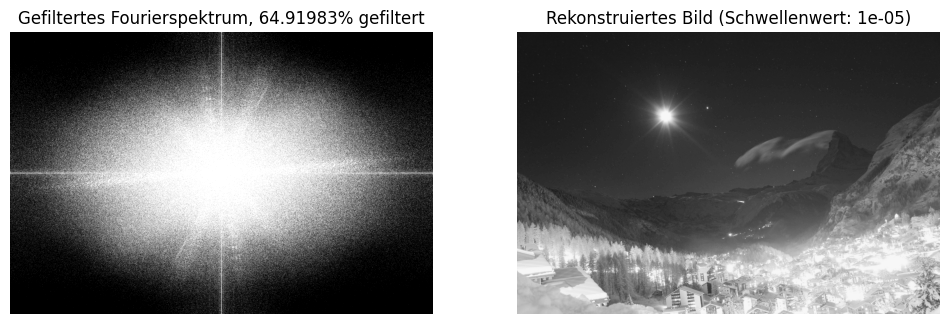

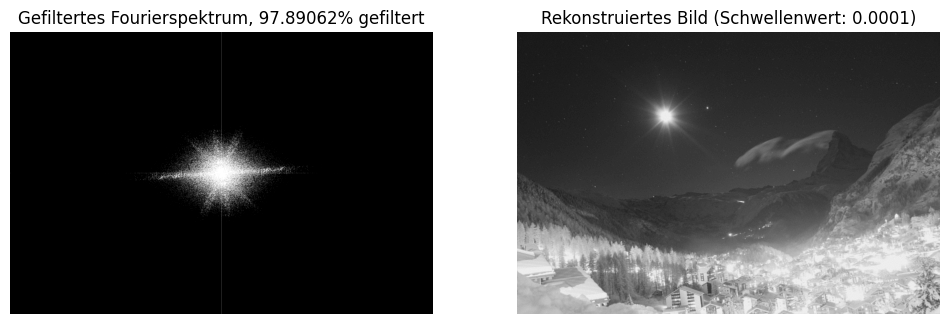

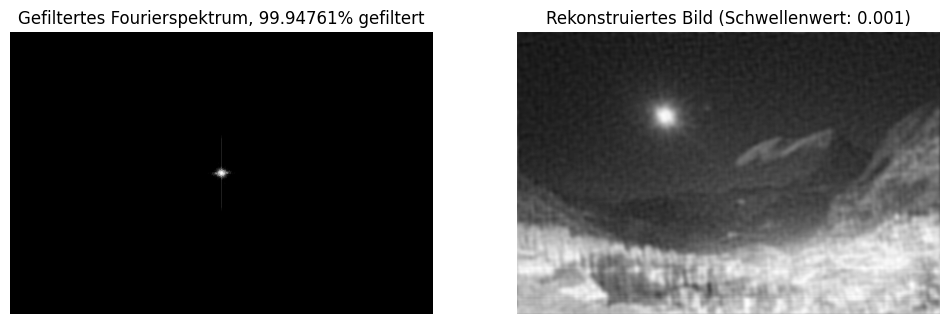

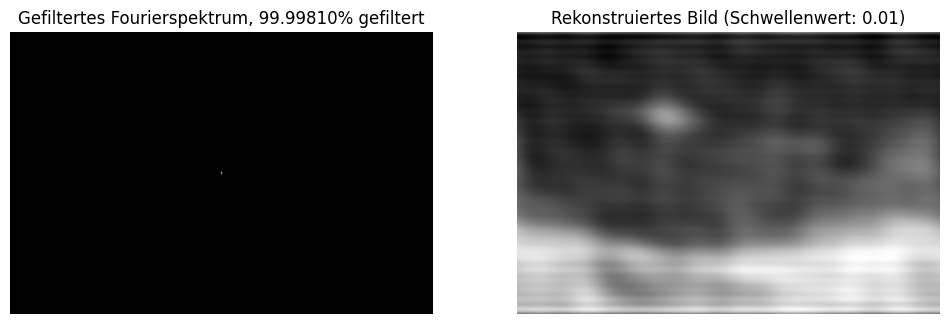

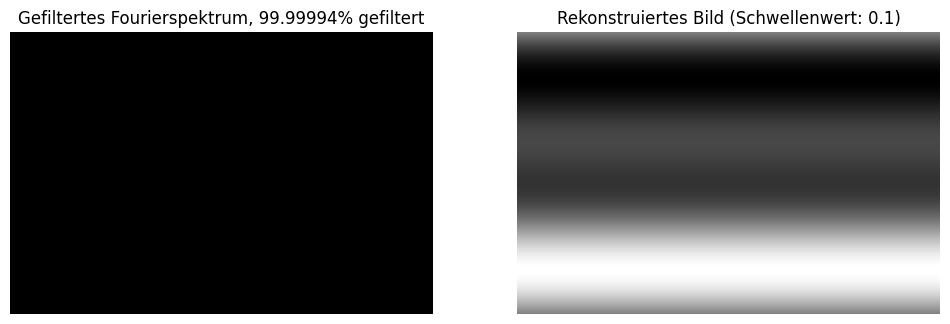

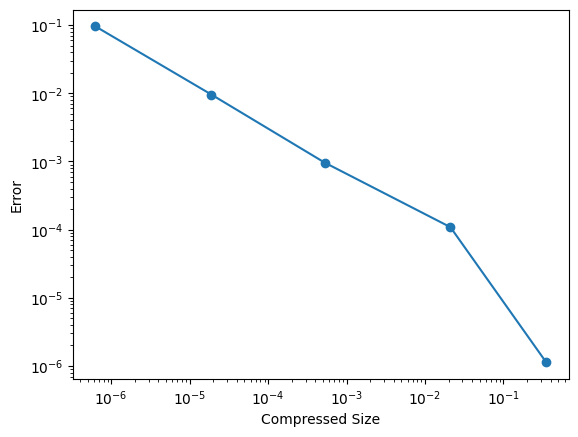



Die Daten können bis zu einem Schwellenwert von 0.01 komprimiert werden, ohne einen Fehler von mehr als 1% zu verursachen.


In [27]:

thresholds = [0.00001, 0.0001, 0.001, 0.01, 0.1]
errors, compress = [], []
for thresh in thresholds:
    # Erstelle eine Kopie der Fourier-Transformierten
    fft_copy = fft_shift.copy()

    # Setze alle Werte unter dem Schwellenwert auf Null
    max_val = np.max(np.abs(fft_copy))
    fft_copy[np.abs(fft_copy) < thresh * max_val] = 0

    # Berechne den Anteil der gefilterten Daten
    filtered_ratio = np.sum(np.abs(fft_copy) == 0) / fft_copy.size
    compress.append(filtered_ratio)

    # Führe die inverse Fourier-Transformation durch
    img_back = np.abs(ifft2(fft_copy))

    # Berechne den Fehler zwischen dem Originalbild und dem rekonstruierten Bild
    err = error(np.array(img), img_back)
    errors.append(err)

    # Erstelle eine 1x2 Subplot-Struktur: links das gefilterte Fourierspektrum, rechts das rekonstruierte Bild
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Zeige das gefilterte Fourierspektrum
    axs[0].imshow(np.abs(fft_copy)==0, cmap="binary")
    axs[0].set_title(f'Gefiltertes Fourierspektrum, {filtered_ratio * 100:.5f}% gefiltert')
    axs[0].axis('off')


    # Zeige das rekonstruierte Bild
    axs[1].imshow(img_back, cmap='gray')
    axs[1].set_title(f'Rekonstruiertes Bild (Schwellenwert: {thresh})')
    axs[1].axis('off')

    plt.show()

plt.plot(1-np.array(compress), errors)
plt.scatter(1-np.array(compress), errors)
plt.xlabel("Compressed Size")
plt.ylabel("Error")
plt.xscale("log")
plt.yscale("log")
plt.show()

# Finde den maximalen Schwellenwert, der einen Fehler von weniger als 1% verursacht
max_thresh = max(thresh for thresh, error in zip(thresholds, errors) if error < 0.01)

print(f'\n\nDie Daten können bis zu einem Schwellenwert von {max_thresh} komprimiert werden, ohne einen Fehler von mehr als 1% zu verursachen.')

Ein Vergleich dier rekonstruierten Bilder zeigt, dass auch wenn der **relative Fehler bei einem Schwellenwert von 0.01 noch unter 1%** liegt, die Rekonstruktion doch erheblich verschwommen ist. Da auch eine Datenkompressionsrate von 98 % ein erheblicher Gewinn ist, sollte ein Schwellenwert von 0.0001 vorgezogen werden, bei dem sich die Rekonstruktion nicht merklich vom Original unterscheidet.
Ungeachtet dessen ist das Potential der Speicherplatzeinsparung klar ersichtlich.

## Zusammenfassung

In diesem Notebook haben wir die Fourier Transformation und ihre verschiedenen Anwendungen vorgestellt: 
 - Approximation von periodischen Funktionen
 - Analyse von Datenreihen, 
 - Musicbearbeitung
 - Bildbearbeitung

Zuerst haben wir mit numpy die komplexe Fourier Approximation implementiert und damit 3 verschieden Funktionen gefittet. Dabei haben wir gesehen, dass **Signale mit Sinus-ähnlicher Schwingung, die nur ueber eine Periode betrachtet werden, hauptsächlich durch die Grundfrequenz $k=1$ bestimmt sind** und **höhere Frequenzen zum Angleichen der Schwingung an die originalen Daten dienen**. Dabei sind nur **relativ wenige Frequenzen nötig**, um eine gute Approximation zu bekommen.
Bei **unstetigen Stellen** am Rande des betrachteten Bereichs hingegen ist eine **gute Näherung beinahe unmöglich** und sollte an diesen Randbereichen vermieden werden. Weitehrin konnten wir sehen, dass **für eine Reihe von $N$ Datenpunkten keine Frequenzen höher als $k=N-1$ in der Fourier Approximation verwendet werden sollten**, da durch Aliasing das Resultat erheblich schlechter wird.

Als nächstes haben wir eine Datenreihe der Anzahl Sonnenflecken über die letzten 300 Jahre betrachtet. Dabei haben wir mithilfe des Fourier Spektrums den **Sonnenzyklus von 11.25 Jahren identifiziert**. Weitehrhin haben wir gezeigt, dass die **Frequenzen unterhalb der dominanten Frequenz die Veränderung der Signalstärke über die Perioden** bestimmt, während die **höheren Frequenzen zur Angleichung des Signals an die Daten** dienen.

Danach haben wir ein kurzes Musikstück mithilfe der Fourier Transformation bearbeitet und die dominanten Frequenzen identifiziert. Bei der Analyse des Spektrums haben wir erkannt, dass **bei reellen Daten die Intensität der negativen Frequenzen mit denen der positiven identisch** ist. Wir haben das Spektrum in einen hoch- und einen niederfrequenten Bereich aufgeteilt und die Rekonstruktionen mit dem Original verglichen. Das Abtrennen der Instrumente mit hohem Klang gelang dabei sehr gut, bei Instrumenten mit tiefem Klang fehlten hingegen Oberschwingungen, die den Klang erst voll machen.

Als letztes haben wir ein Bild mithilfe der Fourier Transformation komprimiert und rekonstruiert. Dabei wir zeigen, dass eine **Komprimierung der Dateigrösse um bis zu 98 % ohne sichtbaren Qualitätsverlust** erreicht werden kann, durch das Abspeichern eines gefilterten Fourier Spektrums, aus dem das Bild rekonstruiert wird, statt das Original zu speichern.

Zusammenfassend konnten wir zeigen, dass die Fourier Transformation ein sehr mächtiges mathematisches Tool ist. Wir konnten einen Einblick geben in die  vielen nützliche Anwendungen, die noch weit über die präsentierten Methoden hinaus reichen.

### Verwendung von GPT
Nahezu der gesamte Code dieses Notebooks wurde direkt und mit weiteren Anweisungen von GPT3.5 erstellt, debugged, optimiert und verschönert.
Die Analyse und Einordnung der Ergebnisse wurden vom Autor selbst verfasst sowie einige Erläuternde Kommentare beigefügt.

## Lerntagebuch
Tag 1 - Musterlösung erstellt

Tag 2 - Musterlösung finalisiert